# Taxi Stay-Point Detection with RAPIDS (cuDF & cuPy)

This notebook implements a highly efficient, GPU-accelerated workflow to identify stay-points from taxi GPS data.

**The overall logic is as follows:**

1.  **Pre-filter in Database**: Extract only relevant low-velocity GPS points from the database to minimize data transfer and memory footprint.
2.  **Load Data to GPU**: Read the pre-filtered data into a cuDF DataFrame.
3.  **Identify Segments**: Detect consecutive sequences of low-velocity points by checking the time (`Δt`) and distance (`Δd`) gaps between them. A large gap indicates a new stay segment.
4.  **Aggregate Segments**: Group the points by segment and calculate metrics for each potential stay-point (start/end times, duration, centroid location).
5.  **Filter by Duration**: Keep only the segments that meet the minimum stay duration threshold (`t_min`).
6.  **Persist Results**: Save the final stay-points to a file or database for further analysis.


## Step 0: Parameters & Environment Setup


In [57]:
import cudf
import cupy as cp
from sqlalchemy import create_engine
import sqlalchemy # For specifying dtype in to_sql
import pandas as pd
import os
from urllib.parse import quote_plus
import subprocess
import psycopg2
import numpy as np
import pyarrow as pa

# parmaeters


In [ ]:
%%sql


In [ ]:

# Thresholds for stay-point detection
VELOCITY_THRESHOLD_KMH = 1.0   # (v_max) Max speed to be considered "low-velocity"
TIME_GAP_THRESHOLD_S =600      # (gap_thr/s) Max time gap in seconds between consecutive points in the same stay
DISTANCE_GAP_THRESHOLD_M = 100  # (dist_thr/m) Optional: Max distance between points to break a stay segment
MIN_STAY_DURATION_S = 600       # (t_min/s) Minimum duration for a sequence of points to be considered a valid stay


# Database connection (optional, for writing results)
username = 'xuhang.liu'
password = 'xuhangLIU@HOMES'
hostname = 'homes-database.epfl.ch'
port = '30767'
dbname = 'Shenzhen_Taxi'
password = quote_plus(password)
DB_URL = f"postgresql://{username}:{password}@{hostname}:{port}/{dbname}"
# --- Custom GPU Haversine Distance Function (replaces cuspatial) ---
def haversine_distance_gpu(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in meters between two points
    on the earth (specified in decimal degrees) using cupy for GPU acceleration.
    """
    # cupy operations require float64 for precision in trig functions
    lon1_rad = cp.radians(lon1.astype(cp.float64))
    lat1_rad = cp.radians(lat1.astype(cp.float64))
    lon2_rad = cp.radians(lon2.astype(cp.float64))
    lat2_rad = cp.radians(lat2.astype(cp.float64))

    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = cp.sin(dlat / 2)**2 + cp.cos(lat1_rad) * cp.cos(lat2_rad) * cp.sin(dlon / 2)**2
    c = 2 * cp.arcsin(cp.sqrt(a))

    # Radius of earth in meters.
    R = 6371000
    return c * R

## Step 1: Data Loading & Preprocessing

In [ ]:
table_name = "taxi_data2020_01_01"
OUTPUT_CSV_PATH = os.path.join(os.getcwd(), 'gps_data_01_01.csv')
print(f"当前目录: {os.getcwd()}")
print(f"输出文件: {OUTPUT_CSV_PATH}")

In [ ]:

# query = f"""
# SELECT
#     gid, taxiid,
#     to_char(time, 'YYYY-MM-DD HH24:MI:SS.US') as time,
#     lon, lat, velocity, angle, passenger, zoneid, validity,
#     hvalue, "OSM_edgeid", "OSM_distance"
# FROM {table_name}
# WHERE  passenger = 0 AND velocity =0 AND time >= '2020-01-01'
# ORDER BY taxiid, time
# """
#
# conn = psycopg2.connect(DB_URL)
# cur = conn.cursor()
#
# with open(OUTPUT_CSV_PATH, 'w', encoding='utf-8') as f:
#     cur.copy_expert(f"COPY ({query}) TO STDOUT WITH CSV HEADER", f)
#
# cur.close()
# conn.close()

In [ ]:

import cudf
import numpy as np

# --- Parameters for Chunked Reading ---
INPUT_CSV_PATH = 'gps_data_01_01.csv'
CHUNK_SIZE = 10_000_000  # 您之前使用的分块大小

# --- Initialization for the Loop ---
list_of_chunks = []
skip_rows_counter = 0
header_read = False
column_names = None

print(f"--- 开始分块读取文件 '{INPUT_CSV_PATH}' ---")

# --- Main Reading Loop ---
while True:
    try:
        # 第一次迭代时，先读取表头获取列名
        if not header_read:
            header_df = cudf.read_csv(INPUT_CSV_PATH, nrows=0)
            column_names = header_df.columns.to_list()
            header_read = True
            skip_rows_counter = 1  # 之后的数据读取从第1行开始（跳过表头）

        # 读取数据块
        chunk = cudf.read_csv(
            INPUT_CSV_PATH,
            nrows=CHUNK_SIZE,
            skiprows=skip_rows_counter,
            header=None,  # 后续读取不再需要表头
            names=column_names,  # 强制使用我们获取的列名
            dtype={
                'taxiid': 'str',
                'lon': np.float32,
                'lat': np.float32,
                'angle': np.int16,
                'zoneid': np.int32,
                'validity': np.int8
            },
            parse_dates=['time']
        )

        if len(chunk) == 0:
            print("--- 所有数据块读取完毕 ---")
            break

        print(f"  - 成功读取一个数据块，包含 {len(chunk):,} 行。")
        list_of_chunks.append(chunk)
        skip_rows_counter += len(chunk)

    except Exception as e:
        print(f"读取文件时发生错误或文件已读完: {e}")
        break

# --- Attempt to Concatenate ---
if list_of_chunks:
    print("\n正在尝试拼接所有数据块...")

    # 注意：下面这行代码就是之前导致 MemoryError 的地方。
    # 我们现在恢复到这里，以便后续可以正确地解决这个问题。
    gdf_01_01 = cudf.concat(list_of_chunks, ignore_index=True)

    print(f"✅ 拼接完成。总行数: {len(gdf_01_01):,}")
    del list_of_chunks
else:
    print("⚠️ 未能从文件中读取任何数据。")
    gdf_01_01 = cudf.DataFrame()

gdf_01_01 = gdf_01_01.dropna()

# timegap


In [ ]:
if not gdf_01_01.empty:
    # --- Calculate gaps within each taxi's trajectory ---

    # 1. Get the previous point's time and coordinates
    # groupby().shift() is a powerful operation to look at the previous record within a group
    gdf_01_01['prev_time'] = gdf_01_01.groupby('taxiid')['time'].shift()
    gdf_01_01['prev_lon'] = gdf_01_01.groupby('taxiid')['lon'].shift().fillna(0)
    gdf_01_01['prev_lat'] = gdf_01_01.groupby('taxiid')['lat'].shift().fillna(0)

    # 2. Calculate time gap in seconds
    # .fillna() is used for the very first point of each taxi, which has no 'previous' time
    gdf_01_01['dt'] = (gdf_01_01['time'] - gdf_01_01['prev_time']).dt.seconds.fillna(99999)

    # 3. Calculate distance gap in meters using our custom GPU function
    # Haversine distance is the shortest distance between two points on a sphere
    gdf_01_01['dd'] = haversine_distance_gpu(
       gdf_01_01['lon'], gdf_01_01['lat'], gdf_01_01['prev_lon'], gdf_01_01['prev_lat']
    )

    print(gdf_01_01.head(5))


## Step 3: Identify Stay Segments

A new stay segment begins when:
1. It's the first point for a given taxi.
2. The time gap (`dt`) from the previous point exceeds `TIME_GAP_THRESHOLD_S`.
3. The distance gap (`dd`) from the previous point exceeds `DISTANCE_GAP_THRESHOLD_M`.

We create a boolean flag for these conditions and then use a cumulative sum (`cumsum`) to assign a unique ID (`grp`) to each segment.


In [ ]:
if not gdf_01_01.empty:
    # --- Flag the start of a new segment ---
    new_segment_flag = (gdf_01_01['dt'] > TIME_GAP_THRESHOLD_S) | \
                       (gdf_01_01['dd'] > DISTANCE_GAP_THRESHOLD_M) | \
                       (gdf_01_01['prev_time'].isnull()) # The first point for each taxi is always a new segment

    # --- Assign a unique ID to each segment ---
    # Convert the boolean Series to a cupy array for cumsum
    # This is a highly efficient way to create group identifiers
    gdf_01_01['grp'] = cp.asarray(new_segment_flag).astype(cp.int32).cumsum()

    print("Assigned segment IDs to all points.")
    print(gdf_01_01.head(5))

## Step 4: Aggregate Segments to Find Stays

Now that each point belongs to a segment (`grp`), we can group by `taxiid` and `grp` to aggregate the data. For each segment, we calculate:
- The start and end time.
- The average longitude and latitude (to find the centroid).
- The number of points in the stay.

Finally, we calculate the duration of each segment and filter out those that are shorter than `MIN_STAY_DURATION_S`.


In [ ]:
if not gdf_01_01.empty:
    # --- Group by segment to create potential stays ---
    agg_stays = gdf_01_01.groupby(['taxiid', 'grp']).agg(
        start_time=('time', 'min'),
        end_time=('time', 'max'),
        stay_lon=('lon', 'mean'),
        stay_lat=('lat', 'mean'),
        points=('taxiid', 'count')
    ).reset_index()

    # --- Calculate duration and filter for valid stays ---
    agg_stays['duration_s'] = (agg_stays['end_time'] - agg_stays['start_time']).dt.seconds

    final_stays = agg_stays[agg_stays['duration_s'] >= MIN_STAY_DURATION_S].copy()
    final_stays = final_stays.sort_values(['taxiid', 'start_time'])
    print(f"Found {len(final_stays)} valid stay-points.")
    print("Final stay-points DataFrame head:")
    print(final_stays.head(20))


In [ ]:
len(final_stays)

# Matching with stations


In [ ]:

from scipy.spatial import cKDTree


In [63]:
# --- Parameters for Matching ---
STATION_CSV_PATH = 'station_information.csv'
DISTANCE_THRESHOLD_M = 200  # Threshold in meters to consider a stay as a charging event

# --- 1. Load Station Data (on CPU) ---
# Create a dummy station file if it doesn't exist for demonstration

stations_df = pd.read_csv(STATION_CSV_PATH,dtype={
                'station_id': np.int32
            })

In [64]:
# --- Refine Station Data with Pile Power Information ---

import pandas as pd

print("--- 开始使用充电桩功率信息优化充电站数据 ---")

try:
    # --- 0. 记录原始数据类型和列名 ---
    # 假设 station_df 是从加载 station_information.csv 开始的
    # 如果不是，可能需要重新加载以保证状态干净
    # stations_df = pd.read_csv('taxi_Shenzhen/station_information.csv') # 如果需要，取消此行注释以重置

    original_station_id_dtype = stations_df['station_id'].dtype
    # 定义我们想要保留的 station_df 的核心列
    core_station_columns = ['station_id', 'longitude', 'latitude', 'TAZID']
    # 检查核心列是否存在，以防万一
    core_station_columns = [col for col in core_station_columns if col in stations_df.columns]

    print(f"记录下 stations_df['station_id'] 的原始数据类型为: {original_station_id_dtype}")

    # --- 1. 加载充电桩数据 ---
    PILE_POWER_CSV_PATH = 'pile_rated_power.csv'
    piles_df = pd.read_csv(PILE_POWER_CSV_PATH)
    print(f"已从 '{PILE_POWER_CSV_PATH}' 加载 {len(piles_df)} 条充电桩记录。")

    # --- 2. 筛选有效充电桩 (0 < 功率 <= 100 kW) ---
    valid_piles_df = piles_df[(piles_df['power'] > 0) & (piles_df['power'] <= 100)].copy()
    print(f"找到 {len(valid_piles_df)} 个功率有效 (0 < power <= 100 kW) 的充电桩。")

    # --- 3. 计算新的功率分类和数量 ---
    valid_piles_df['low_power_piles'] = (valid_piles_df['power'] < 10).astype(int)
    valid_piles_df['high_power_piles'] = (valid_piles_df['power'] >= 10).astype(int)

    station_counts_df = valid_piles_df.groupby('station_id').agg(
        low_power_piles=('low_power_piles', 'sum'),
        high_power_piles=('high_power_piles', 'sum')
    ).reset_index()
    print(f"已为 {len(station_counts_df)} 个至少拥有一个有效充电桩的站点聚合了桩数。")

    # --- 4. 稳健地清理并合并 ---

    # 4a. 准备合并：检查并临时统一ID类型以确保合并成功
    temp_stations_df = stations_df.copy()
    temp_counts_df = station_counts_df.copy()

    if temp_stations_df['station_id'].dtype != temp_counts_df['station_id'].dtype:
        print("检测到 station_id 类型不匹配，临时转换为 float 以进行合并。")
        temp_stations_df['station_id'] = temp_stations_df['station_id'].astype(float)
        temp_counts_df['station_id'] = temp_counts_df['station_id'].astype(float)

    # 4b. 【关键修改】只选择核心列，而不是删除列
    stations_df_cleaned = temp_stations_df[core_station_columns]

    # 4c. 执行内连接
    stations_df_updated = pd.merge(
        stations_df_cleaned,
        temp_counts_df,
        on='station_id',
        how='inner'
    )
    print(f"合并后，剩余 {len(stations_df_updated)} 个有效充电站。")

    # --- 5. 收尾工作 ---
    # 5a. 更新总充电桩数列
    stations_df_updated['charge_count'] = stations_df_updated['low_power_piles'] + stations_df_updated['high_power_piles']

    # 5b. 恢复原始数据类型
    try:
        stations_df_updated['station_id'] = stations_df_updated['station_id'].astype(original_station_id_dtype)
        print(f"成功将 station_id 恢复为原始数据类型: {original_station_id_dtype}")
    except Exception as e:
        print(f"警告: 无法将 station_id 恢复为 {original_station_id_dtype}。错误: {e}")

    # 5c. 将原始的 stations_df 替换为优化后的版本
    stations_df = stations_df_updated

    # --- 6. 最终输出 ---
    print("\n" + "="*30)
    print("✅ 充电站数据优化完成")
    print("="*30)
    print(f"最终充电站数量: {len(stations_df)}")
    print(f"最终 station_id 数据类型: {stations_df['station_id'].dtype}")
    print("\n数据表头:")
    print(stations_df.head())
    print("\n新的列名:")
    print(stations_df.columns)

except FileNotFoundError:
    print(f"错误: 充电桩功率文件 '{PILE_POWER_CSV_PATH}' 未找到。处理中止。")
except Exception as e:
    print(f"处理充电桩数据时发生错误: {e}")




--- 开始使用充电桩功率信息优化充电站数据 ---
记录下 stations_df['station_id'] 的原始数据类型为: int32
已从 'pile_rated_power.csv' 加载 22650 条充电桩记录。
找到 20436 个功率有效 (0 < power <= 100 kW) 的充电桩。
已为 1489 个至少拥有一个有效充电桩的站点聚合了桩数。
检测到 station_id 类型不匹配，临时转换为 float 以进行合并。
合并后，剩余 1489 个有效充电站。
成功将 station_id 恢复为原始数据类型: int32

✅ 充电站数据优化完成
最终充电站数量: 1489
最终 station_id 数据类型: int32

数据表头:
   station_id   longitude   latitude  TAZID  low_power_piles  \
0        1001  113.784724  22.714121    559               20   
1        1002  113.785002  22.725900    558               22   
2        1003  113.787971  22.735538    558                6   
3        1004  113.788126  22.693449    596                6   
4        1006  113.790987  22.731351    594               20   

   high_power_piles  charge_count  
0                 0            20  
1                 0            22  
2                 0             6  
3                 5            11  
4                 0            20  

新的列名:
Index(['station_id', 'longitude', 'latitude', 'TAZI

In [ ]:

# --- 2. Build cKDTree from Station Coordinates (on CPU) ---
# This assumes both GPS and station data use the WGS-84 coordinate system.
station_coords = stations_df[['longitude', 'latitude']].to_numpy()
station_tree = cKDTree(station_coords)
print("cKDTree built successfully from station data.")



In [65]:
# --- 3. Query the Tree with Stay-Points ---
# Check if the 'final_stays' DataFrame from the previous step exists
if not final_stays.empty:


    # 3a. Transfer stay-point coordinates from GPU to CPU
    stay_coords = final_stays[['stay_lon', 'stay_lat']].to_numpy()

    # 3b. Perform the nearest neighbor query using the cKDTree

    distances_deg, indices = station_tree.query(stay_coords, k=1)


    # 3c. Convert distance from degrees to approximate meters.
    # This approximation (1 degree ≈ 111.32 km) is valid for city-scale analysis.
    distances_m = distances_deg * 111320

    # --- 4. Add Matching Results back to the GPU DataFrame ---

    # Transfer the numpy arrays from CPU back to GPU as new cudf Series
    final_stays['distance_to_station_m'] = distances_m

    # Map the indices from the query result back to the original station_id
    station_id_lookup = stations_df['station_id'].to_numpy()
    nearest_station_ids = station_id_lookup[indices]
    final_stays['nearest_station_id'] = cudf.Series(nearest_station_ids, index=final_stays.index)

    # --- 5. Filter for Charging Events based on the distance threshold ---

    charging_events = final_stays[final_stays['distance_to_station_m'] <= DISTANCE_THRESHOLD_M].copy()
    charging_events = charging_events.sort_values(['taxiid', 'start_time'])


else:
    print("\n'final_stays' DataFrame not found or is empty. Please run the preceding cells to generate stay-points first.")


In [66]:
len(charging_events)

164866

In [67]:
charging_events['taxiid'].nunique()

19417

In [68]:
import pyarrow.parquet as pq

# --- 1. Prepare data for queue simulation ---
# The 'charging_events' DataFrame is on the GPU (cudf).
# The 'stations_df' DataFrame is on the CPU (pandas) and has the 'charge_count'.

# Create a clean pandas version of charging events
# We only need specific columns for the simulation to save memory.
if 'charging_events' in locals() and not charging_events.empty:

    # Select necessary columns and move to pandas
    queue_input_df = charging_events[[
        'nearest_station_id', 'taxiid', 'start_time', 'end_time'
    ]].to_pandas()

    # Merge with station info to get the number of chargers at each station
    queue_input_df = queue_input_df.merge(
        stations_df[['station_id', 'charge_count']],
        left_on='nearest_station_id',
        right_on='station_id',
        how='left'
    )

    # Drop the redundant station_id column and handle cases where charge_count might be missing
    #queue_input_df = queue_input_df.drop(columns=['station_id'])
    queue_input_df['charge_count'] = queue_input_df['charge_count'].fillna(1).astype(int) # Assume at least 1 charger if info is missing

    # --- 2. Save to Parquet for efficient batch processing ---
    QUEUE_INPUT_PARQUET = 'charging_events_for_queue_sim.parquet'
    queue_input_df.to_parquet(QUEUE_INPUT_PARQUET)

    print(f"Prepared data for queue simulation with {len(queue_input_df)} events.")
    print(f"Saved to '{QUEUE_INPUT_PARQUET}'.")
    print("\nData head:")
    print(queue_input_df.head())

else:
    print("'charging_events' DataFrame not found or is empty. Cannot proceed with queue simulation.")



Prepared data for queue simulation with 164866 events.
Saved to 'charging_events_for_queue_sim.parquet'.

Data head:
   nearest_station_id     taxiid          start_time            end_time  \
0                2266  UUUB0C0M7 2020-01-02 01:22:09 2020-01-02 01:35:09   
1                2143  UUUB0C0M7 2020-01-02 20:03:06 2020-01-02 20:17:51   
2                2330  UUUB0C0M7 2020-01-04 04:34:23 2020-01-04 04:57:53   
3                2159  UUUB0C0M7 2020-01-05 02:24:03 2020-01-05 02:36:17   
4                2159  UUUB0C0M7 2020-01-06 01:55:31 2020-01-06 02:09:20   

   station_id  charge_count  
0        2266             6  
1        2143             8  
2        2330             6  
3        2159             2  
4        2159             2  


In [ ]:
len(queue_input_df)

In [ ]:
queue_input_df['taxiid'].nunique()

In [69]:
# 1. 找出在 charging_events 中出现过的所有车辆
charging_taxi_ids = charging_events['taxiid'].nunique()

# 2. 找出在 results_df 中出现过的所有车辆
results_taxi_ids = queue_input_df['taxiid'].nunique()

# 3. 计算差集，找出只在前者中出现的车辆
# .to_pandas() 是为了能使用 set 操作
disappeared_taxis = charging_taxi_ids- results_taxi_ids

print(f"在 'charging_events' 中独有的车辆数量: {(disappeared_taxis)}")
print(f"计算出的理论差值: {19417 - 15185}")

# 您还可以打印出几个“消失”的车辆ID
# print("\n几个'消失'的车辆 ID 示例:")
# print(list(disappeared_taxis)[:5])

在 'charging_events' 中独有的车辆数量: 0
计算出的理论差值: 4232


### Queue Simulation for Waiting Time Calculation

This section implements the core logic for estimating charging queue times.

-   **Input**: The Parquet file created above, containing charging events sorted by station and arrival time.
-   **Algorithm**: It processes each charging station's data as a stream. A min-heap data structure tracks the finish time of cars currently occupying chargers. This allows for an efficient O(N log K) calculation, where N is the number of events and K is the number of chargers at a station.
-   **Output**: A new Parquet file (`charging_analysis.parquet`) containing the original event data plus new columns: `wait_s`, `giveup`, and `charge_s`.


In [70]:
from heapq import heappush, heappop

# --- Parameters for Simulation ---
SRC_PARQUET = 'charging_events_for_queue_sim.parquet'
DST_PARQUET = 'charging_analysis.parquet'
BATCH_SIZE = 5_000_000  # Process 5 million rows at a time

def process_station(df):
    """
    Simulates the queue for a single station.
    Assumes the input DataFrame 'df' is for one station and sorted by 'start_time'.
    """
    if df.empty:
        return pd.DataFrame()

    k = int(df['charge_count'].iloc[0])
    busy_chargers_heap = []  # A min-heap storing the end_time of cars currently charging
    results = []

    for row in df.itertuples():
        arrival_time = row.start_time
        departure_time = row.end_time

        # Step 1: Remove chargers that have become free before the current car arrives
        while busy_chargers_heap and busy_chargers_heap[0] <= arrival_time:
            heappop(busy_chargers_heap)

        # Step 2: Check for available chargers
        if len(busy_chargers_heap) < k:
            # There is a free charger, no waiting time
            wait_seconds = 0
            actual_charge_start_time = arrival_time
        else:
            # All chargers are busy, must queue. Find the earliest time a charger becomes free.
            earliest_free_time = heappop(busy_chargers_heap)
            wait_seconds = (earliest_free_time - arrival_time).total_seconds()
            actual_charge_start_time = earliest_free_time

        # Step 3: Determine if the driver gave up
        stay_duration_seconds = (departure_time - arrival_time).total_seconds()
        gave_up = (wait_seconds >= stay_duration_seconds)

        # Step 4: Calculate actual charge duration and update charger status
        if gave_up:
            actual_charge_seconds = 0
            # If the car gave up, the charger it was waiting for is free again at its scheduled time
            if 'earliest_free_time' in locals():
                 heappush(busy_chargers_heap, earliest_free_time)
        else:
            actual_charge_seconds = (departure_time - actual_charge_start_time).total_seconds()
            # This car occupies a charger until its departure time
            heappush(busy_chargers_heap, departure_time)

        results.append({
            'station_id': row.nearest_station_id,
            'taxiid': row.taxiid,
            'arrive_time': arrival_time,
            'leave_time': departure_time,
            'wait_s': wait_seconds,
            'giveup': gave_up,
            'charge_s': actual_charge_seconds
        })

    return pd.DataFrame(results)

# --- Main Batch Processing Loop ---
if os.path.exists(SRC_PARQUET):
    reader = pq.ParquetFile(SRC_PARQUET)
    writer = None

    print(f"Starting queue simulation from '{SRC_PARQUET}'...")
    for i, batch in enumerate(reader.iter_batches(batch_size=BATCH_SIZE)):
        print(f"  Processing batch {i+1}...")
        pdf = batch.to_pandas()

        # Sort by station and time to ensure correct processing order
        pdf = pdf.sort_values(['nearest_station_id', 'start_time'], kind='mergesort')

        # Process each station group within the batch
        all_station_results = [
            process_station(group)
            for _, group in pdf.groupby('nearest_station_id', sort=False)
        ]

        # Concatenate results and write to the output Parquet file
        if all_station_results:
            output_batch_df = pd.concat(all_station_results, ignore_index=True)
            table = pa.Table.from_pandas(output_batch_df)

            if writer is None:
                writer = pq.ParquetWriter(DST_PARQUET, table.schema)
            writer.write_table(table)

    if writer:
        writer.close()
    print(f"✅ Queue simulation finished. Results saved to '{DST_PARQUET}'.")
else:
    print(f"Source file '{SRC_PARQUET}' not found. Cannot run simulation.")



Starting queue simulation from 'charging_events_for_queue_sim.parquet'...
  Processing batch 1...
✅ Queue simulation finished. Results saved to 'charging_analysis.parquet'.


In [71]:
# --- Quick Stats & Validation ---
if os.path.exists(DST_PARQUET):
    # Read the final results into a pandas DataFrame
    results_df = pd.read_parquet(DST_PARQUET)

    print("\n--- Queue Simulation Results ---")
    print(f"Total processed events: {len(results_df)}")

    # Calculate and print key metrics
    avg_wait_time = results_df['wait_s'].mean()
    giveup_rate = results_df['giveup'].mean()

    print(f"\nAverage waiting time: {avg_wait_time:.2f} seconds")
    print(f"Give-up rate: {giveup_rate:.2%}")

    print("\nResults DataFrame head:")
    print(results_df.head())

    # Example of further analysis: find the station with the longest average wait time
    avg_wait_by_station = results_df.groupby('station_id')['wait_s'].mean().sort_values(ascending=False)
    print("\n--- Top 5 Stations with Longest Average Wait Time ---")
    print(avg_wait_by_station.head(5))

else:
    print(f"Result file '{DST_PARQUET}' not found.")




--- Queue Simulation Results ---
Total processed events: 164866

Average waiting time: 475.67 seconds
Give-up rate: 10.27%

Results DataFrame head:
   station_id      taxiid         arrive_time          leave_time  wait_s  \
0        1001  UUUBD48125 2020-01-01 12:17:42 2020-01-01 12:34:23     0.0   
1        1001  UUUBD00847 2020-01-03 01:57:32 2020-01-03 02:07:32     0.0   
2        1001  UUUBD70477 2020-01-07 07:42:30 2020-01-07 07:53:07     0.0   
3        1002  UUUBDG8513 2020-01-02 10:20:36 2020-01-02 10:32:06     0.0   
4        1003  UUUBDF6978 2020-01-04 18:17:43 2020-01-04 18:28:58     0.0   

   giveup  charge_s  
0   False    1001.0  
1   False     600.0  
2   False     637.0  
3   False     690.0  
4   False     675.0  

--- Top 5 Stations with Longest Average Wait Time ---
station_id
1232    12345.217877
1983     6234.323843
1991     4993.106157
1775     2753.556911
1604     2443.612267
Name: wait_s, dtype: float64


In [72]:
results_df['taxiid'].nunique()

19417

# Visualization

In [73]:
# --- 分析: 平均每日充电次数 ---

print("--- 正在计算平均每日充电次数 ---")

# 确保 'results_df' 存在且不为空
if 'results_df' in locals() and not results_df.empty:

    # --- 1. 提取充电日期 ---
    # .dt.date 用于从 datetime 对象中仅提取日期部分
    results_df['charge_date'] = results_df['arrive_time'].dt.date

    # --- 2. 计算每辆车每天的成功充电次数 ---
    # 我们只统计没有放弃 ('giveup' == False) 的充电事件
    # daily_charges_per_taxi = results_df[results_df['giveup'] == False].groupby(['taxiid', 'charge_date']).size().reset_index
    daily_charges_per_taxi = results_df.groupby(['taxiid', 'charge_date']).size().reset_index(name='daily_charge_count')
    print("\n--- 每辆车每日充电次数 (示例) ---")
    print(daily_charges_per_taxi.head())

    # --- 3. 计算每辆车的“平均每日充电次数” ---
    # 对上一步的结果再次 groupby，这次只按 taxiid，然后求均值
    avg_daily_charges_per_taxi = daily_charges_per_taxi.groupby('taxiid')['daily_charge_count'].mean().reset_index(name='avg_daily_charges')
    print("\n--- 每辆车的平均每日充电次数 (示例) ---")
    print(avg_daily_charges_per_taxi.head())

    # --- 4. 计算所有车的总平均每日充电次数 ---
    # 直接对 'avg_daily_charges' 这一列求均值
    overall_avg_daily_charges = avg_daily_charges_per_taxi['avg_daily_charges'].mean()
    print("\n" + "="*40)
    print(f"✅ 所有车辆的平均每日充电次数为: {overall_avg_daily_charges:.2f} 次/天/车")
    print("="*40)

else:
    print("错误: 'results_df' 未找到或为空。请先运行队列模拟部分的单元格。")


--- 正在计算平均每日充电次数 ---

--- 每辆车每日充电次数 (示例) ---
      taxiid charge_date  daily_charge_count
0  UUUB0C0M7  2020-01-02                   2
1  UUUB0C0M7  2020-01-04                   1
2  UUUB0C0M7  2020-01-05                   1
3  UUUB0C0M7  2020-01-06                   1
4  UUUB0C0M7  2020-01-07                   1

--- 每辆车的平均每日充电次数 (示例) ---
      taxiid  avg_daily_charges
0  UUUB0C0M7           1.200000
1  UUUB0C0P3           1.500000
2  UUUB0C0P5           2.400000
3  UUUB0C0Q5           2.000000
4  UUUB0C0Q9           2.333333

✅ 所有车辆的平均每日充电次数为: 1.78 次/天/车


In [74]:
# --- 分析: 停留与等待时间的分布统计 ---

import numpy as np

print("--- 正在计算停留与等待时间的描述性统计 ---")

if 'results_df' in locals() and not results_df.empty:
    # --- 1. 准备数据 ---
    # 如果 'stay_duration_s' 不存在，则从时间戳计算
    if 'stay_duration_s' not in results_df.columns:
        results_df['stay_duration_s'] = (results_df['leave_time'] - results_df['arrive_time']).dt.total_seconds()

    # 为了更好地可视化和理解，我们将秒转换为分钟
    results_df['wait_minutes'] = results_df['wait_s'] / 60
    results_df['stay_duration_minutes'] = results_df['stay_duration_s'] / 60

    # --- 2. 输出描述性统计 ---
    print("\n--- 排队时间 (分钟) 的描述性统计 ---")
    # 使用 .describe() 查看分布，特别是 50% (中位数), 75%, max 等
    # percentiles 参数可以自定义需要查看的百分位数
    print(results_df['wait_minutes'].describe(percentiles=[.25, .5, .75, .9, .95, .99]))

    print("\n--- 总停留时长 (分钟) 的描述性统计 ---")
    print(results_df['stay_duration_minutes'].describe(percentiles=[.25, .5, .75, .9, .95, .99]))

else:
    print("错误: 'results_df' 未找到或为空。请先运行队列模拟部分的单元格。")

--- 正在计算停留与等待时间的描述性统计 ---

--- 排队时间 (分钟) 的描述性统计 ---
count    164866.000000
mean          7.927869
std          26.491577
min           0.000000
25%           0.000000
50%           0.000000
75%          10.216667
90%          22.983333
95%          33.866667
99%          69.422500
max        1431.250000
Name: wait_minutes, dtype: float64

--- 总停留时长 (分钟) 的描述性统计 ---
count    164866.000000
mean         24.218820
std          27.095239
min          10.000000
25%          13.000000
50%          17.866667
75%          25.350000
90%          40.750000
95%          57.233333
99%         124.333333
max        1481.666667
Name: stay_duration_minutes, dtype: float64


--- 正在生成停留与等待时间的分布直方图 ---


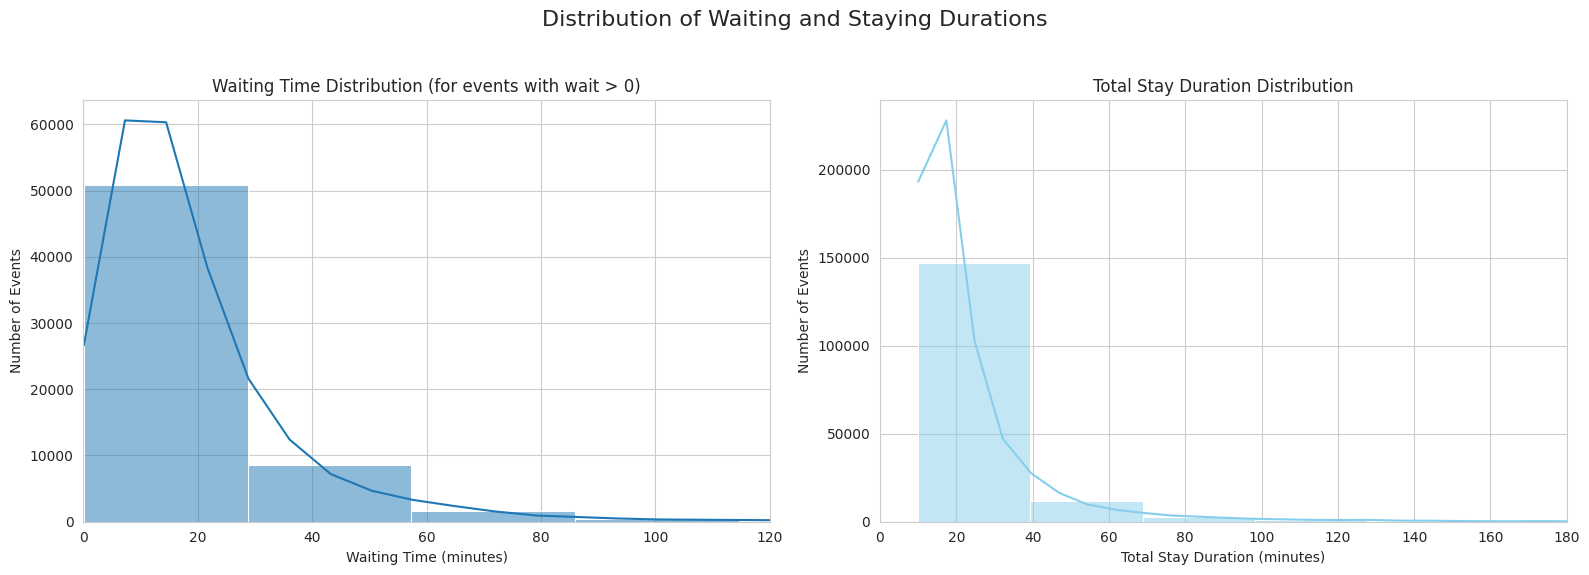

In [75]:
# --- 可视化: 停留与等待时间的分布直方图 ---

import matplotlib.pyplot as plt
import seaborn as sns

print("--- 正在生成停留与等待时间的分布直方图 ---")

if 'results_df' in locals() and 'wait_minutes' in results_df.columns:
    # 设置绘图风格
    sns.set_style("whitegrid")

    # 创建一个 1x2 的子图布局
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Distribution of Waiting and Staying Durations', fontsize=16)

    # a) 排队时间直方图
    # 为了使图形更有意义，我们只关注那些实际需要排队的事件 (wait_minutes > 0)
    waiting_events_df = results_df[results_df['wait_minutes'] > 0.1] # 使用0.1避免浮点数精度问题
    sns.histplot(data=waiting_events_df, x='wait_minutes', bins=50, ax=axes[0], kde=True)
    axes[0].set_title('Waiting Time Distribution (for events with wait > 0)')
    axes[0].set_xlabel('Waiting Time (minutes)')
    axes[0].set_ylabel('Number of Events')
    # 限制 x 轴范围以便更好地观察主要分布，例如最多看 2 小时
    axes[0].set_xlim(0, 120)

    # b) 总停留时长直方图
    sns.histplot(data=results_df, x='stay_duration_minutes', bins=50, ax=axes[1], color='skyblue', kde=True)
    axes[1].set_title('Total Stay Duration Distribution')
    axes[1].set_xlabel('Total Stay Duration (minutes)')
    axes[1].set_ylabel('Number of Events')
    # 限制 x 轴范围，例如最多看 3 小时
    axes[1].set_xlim(0, 180)

    # 调整布局以防止标题重叠并显示图像
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

else:
    print("错误: 'results_df' 或 'wait_minutes' 列未找到。请先运行前面的统计单元格。")

In [25]:
import folium
from folium.plugins import MarkerCluster

In [27]:

# 1. 准备数据（都在 CPU）
stations_pdf = pd.read_csv('station_information.csv')  # 充电站
charging_pdf = charging_events.to_pandas()             # 充电行为（距离阈值内的停留点）

# 2. 计算地图中心（深圳大致中心 or 所有点的平均）
center_lat = charging_pdf['stay_lat'].mean()
center_lon = charging_pdf['stay_lon'].mean()

# 3. 创建底图
m = folium.Map(location=[center_lat, center_lon],
               zoom_start=11,
               tiles='OpenStreetMap')

# # 4. 充电站：用 MarkerCluster 以免过度遮挡
# station_cluster = MarkerCluster(name='Charging Stations').add_to(m)
# for _, row in stations_pdf.iterrows():
#     folium.CircleMarker(
#         location=[row['latitude'], row['longitude']],
#         radius=4,
#         color='blue',
#         fill=True,
#         fill_color='blue',
#         fill_opacity=0.7,
#         popup=f"Station ID: {row['station_id']}"
#     ).add_to(station_cluster)

# 5. 充电行为：红色半透明圆
charge_cluster = MarkerCluster(name='Charging Events').add_to(m)
for _, row in charging_pdf.iterrows():
    folium.CircleMarker(
        location=[row['stay_lat'], row['stay_lon']],
        radius=6,                      # 可改为 min(row['duration_s']/60, 10) 表示时长
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.5,
        popup=(f"TaxiID: {row['taxiid']}<br>"
               f"Start: {row['start_time']}<br>"
               f"End: {row['end_time']}<br>"
               f"Duration: {row['duration_s']} s<br>"
               f"Dist to Station: {row['distance_to_station_m']:.1f} m<br>"
               f"Station ID: {row['nearest_station_id']}")
    ).add_to(charge_cluster)

# 6. 图例/图层控制
folium.LayerControl().add_to(m)

# 7. 显示
m